In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn ##Install Required Libraries


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [7]:
# Set random seed for reproducibility
np.random.seed(42)

In [8]:
df = pd.read_csv("C:\\Users\\aaliy\\Documents\\ai_assistant_usage_student_life.csv") ##Load the Dataset


In [ ]:
#Explore the dataset
print(df.head())
print(df.tail())
print(df.info())  
print(df.shape)  
print(df.dtypes)
print(df.describe())
print(df.isnull().sum())


      SessionID   StudentLevel        Discipline SessionDate  \
0  SESSION00001  Undergraduate  Computer Science  2024-11-03   
1  SESSION00002  Undergraduate        Psychology  2024-08-25   
2  SESSION00003  Undergraduate          Business  2025-01-12   
3  SESSION00004  Undergraduate  Computer Science  2025-05-06   
4  SESSION00005  Undergraduate        Psychology  2025-03-18   

   SessionLengthMin  TotalPrompts  TaskType  AI_AssistanceLevel  \
0             31.20            11  Studying                   2   
1             13.09             6  Studying                   3   
2             19.22             5    Coding                   3   
3              3.70             1    Coding                   3   
4             28.12             9   Writing                   3   

           FinalOutcome  UsedAgain  SatisfactionRating  
0  Assignment Completed       True                 1.0  
1  Assignment Completed       True                 2.0  
2  Assignment Completed       True       

In [10]:
print(df.columns)

Index(['SessionID', 'StudentLevel', 'Discipline', 'SessionDate',
       'SessionLengthMin', 'TotalPrompts', 'TaskType', 'AI_AssistanceLevel',
       'FinalOutcome', 'UsedAgain', 'SatisfactionRating'],
      dtype='object')


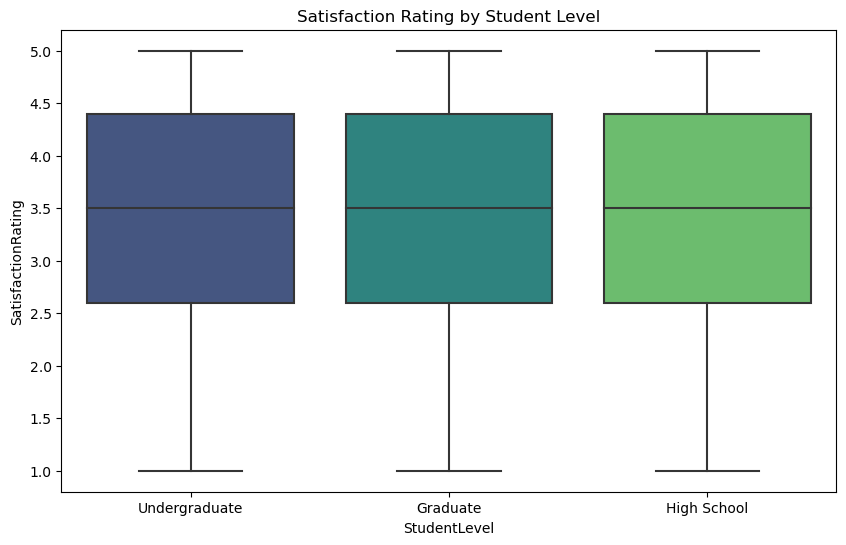

In [16]:
#Visualize Key Insights
plt.figure(figsize=(10, 6))
sns.boxplot(x='StudentLevel', y='SatisfactionRating', data=df, palette='viridis')
plt.title('Satisfaction Rating by Student Level')
plt.show()

In [17]:
#Fill missing categorical columns with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'UsedAgain':
        df[col] = df[col].fillna('Unknown')

In [19]:
#Fill missing numeric columns with median
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
#Check for missing values in target column, to clean the target before modeling
print("\nMissing values in target column 'UsedAgain':", df['UsedAgain'].isnull().sum())


Missing values in target column 'UsedAgain': 0


In [21]:
#Fill missing values in 'UsedAgain' with 'No' as default
df['UsedAgain'] = df['UsedAgain']. fillna('No')

In [22]:
# Encode Categorical Variables
df['UsedAgainEncoded'] = df['UsedAgain'] .map({True: 1, False: 0, 'Yes': 1, 'No': 0})

In [23]:
#Drop rows with missing target
df = df.dropna(subset=['UsedAgainEncoded'])

In [25]:
#Encoding categorical variables for Bias Detection
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string to avoid errors with NaN values
    label_encoders[col] = le

In [35]:
#Creating New Features: Prompts per minute
if all(c in df.columns for c in ['TotalPrompts', 'SessionLengthMin']):
    df['PromptsPerMinute'] = np.where(df['SessionLengthMin'] > 0, df['TotalPrompts'] / df['SessionLengthMin'], 0)
else:
    print(" Missing columns for PromptsPerMinute. Setting to 0.")
    df['PromptsPerMinute'] = 0

In [38]:
#...:Session Hour
if 'SessionDate' in df.columns:
    df['SessionDate'] = pd.to_datetime(df['SessionDate'], errors='coerce')
    df['SessionHour'] = df['SessionDate'].dt.hour.fillna(0).astype(int)
else:
    print(" SessionDate column missing. Setting SessionHour to 0.")
    df['SessionHour'] = 0
  # Fill NaN with 0 and convert to int

In [39]:
#...:Long Session Indicator
if 'SessionLengthMin' in df.columns:
    df['IsLongSession'] = (df['SessionLengthMin'] > 30).astype(int)
else:
    print(" SessionLengthMin column missing. Setting IsLongSession to 0.")
    df['IsLongSession'] = 0 # Convert to int (1 for True, 0 for False)

In [43]:
#Scaling Numerical Features
scaler = StandardScaler()
scale_cols = ['SessionLengthMin', 'TotalPrompts', 'SatisfactionRating', 'PromptsPerMinute']
scale_cols = [col for col in scale_cols if col in df.columns]



In [52]:
#...using standardscaler to transform the selected columns
if scale_cols:
    try:
        df[[f"{col}_scaled" for col in scale_cols]] = scaler.fit_transform(df[scale_cols])
        #...catch any errors during scaling
    except ValueError as e:
        print(f"Scaling failed for {scale_cols}: {e}. Setting scaled columns to 0.")
        for col in scale_cols:
            df[f"{col}_scaled"] = 0
            #...If no columns to scale, set scaled columns to 0
else:
    
    print("No columns to scale. Setting scaled columns to 0.")
    for col in scale_cols:
        df[f"{col}_scaled"] = 0

In [ ]:
#Preparing for model...Define feature, excluding non-informative or target columns.creating list of feature columns for modeling
excluded_cols = {'SessionID', 'UsedAgain', 'UsedAgainEncoded', 'SessionDate'}
features = [col for col in df.columns if col not in excluded_cols and df[col].dtype in [np.float64, np.int32, np.int64]]

In [58]:
x = df[features]
y = df['UsedAgainEncoded']

In [59]:
#Check data shapes
print("\n Data shapes:")
print(f"x shape : {x.shape}")
print(f"y shape : {y.shape}")


 Data shapes:
x shape : (10000, 15)
y shape : (10000,)


In [60]:
#Validate dataset
if x.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("No samples remain after preprocessing - check dataset contents.")

In [61]:
if x.empty:
    raise ValueError("No features selected - check dataset columns.")

In [62]:
#Train_tTest Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Training model (Creating a Random Forest Model)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [65]:
#Performance evaluation
y_pred = model.predict(x_test)

In [66]:
#calculating overall accuracy
print(f"\n Accuracy: {accuracy_score(y_test, y_pred): .2%}")


 Accuracy:  71.80%


In [67]:
#Getting detailed performance metrics
print("\nClassification Report:")
print (classification_report(y_test, y_pred, target_names=['No', 'Yes']))


Classification Report:
              precision    recall  f1-score   support

          No       0.54      0.29      0.38       587
         Yes       0.75      0.89      0.82      1413

    accuracy                           0.72      2000
   macro avg       0.64      0.59      0.60      2000
weighted avg       0.69      0.72      0.69      2000



In [ ]:
#Displays confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

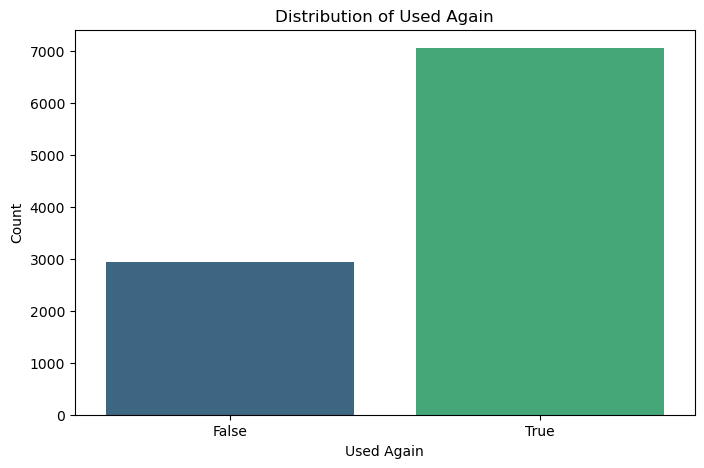

In [68]:
#Visualizing the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='UsedAgain', data=df, palette= 'viridis')
plt.title('Distribution of Used Again')
plt.xlabel('Used Again')
plt.ylabel('Count')
plt.show()

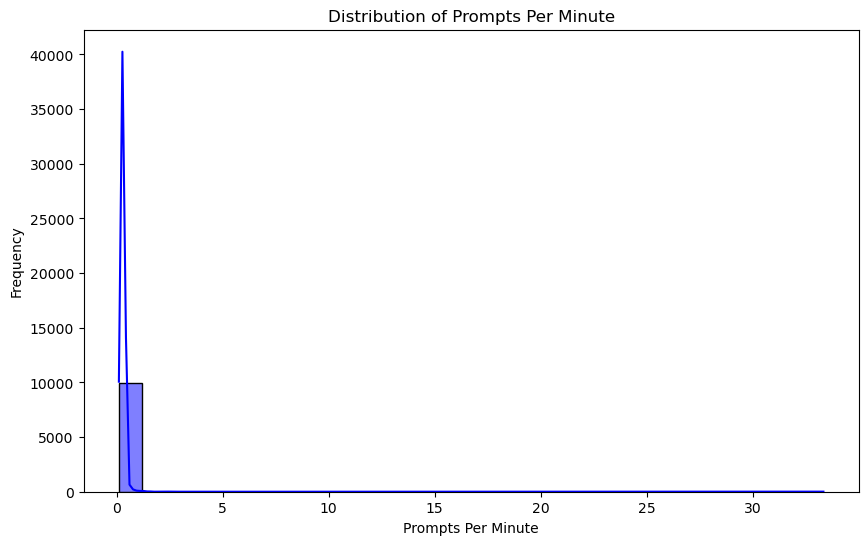

In [69]:
#Prompts per minute distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['PromptsPerMinute'], bins=30, kde=True, color='blue')
plt.title('Distribution of Prompts Per Minute')
plt.xlabel('Prompts Per Minute')
plt.ylabel('Frequency')
plt.show()

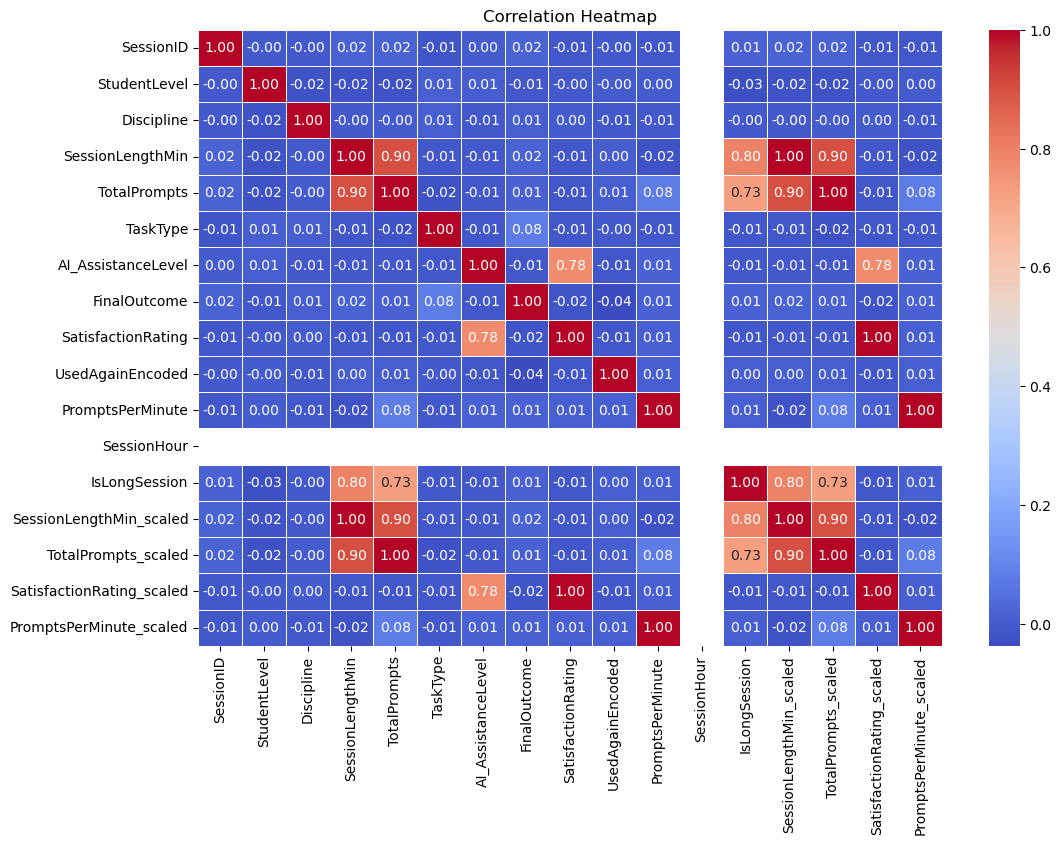

In [70]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

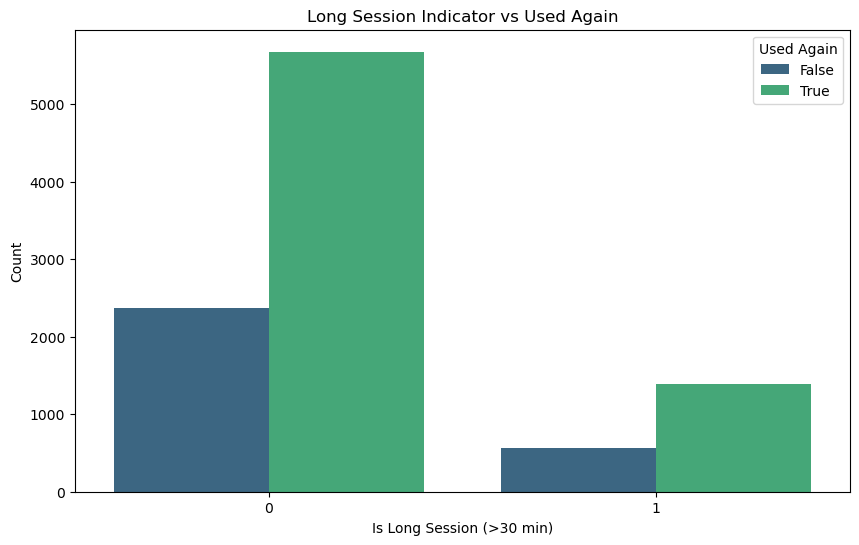

In [71]:
plt.figure(figsize=(10, 6))
sns.countplot(x='IsLongSession', hue='UsedAgain', data=df, palette='viridis')
plt.title('Long Session Indicator vs Used Again')
plt.xlabel('Is Long Session (>30 min)')
plt.ylabel('Count')
plt.legend(title='Used Again')
plt.show()

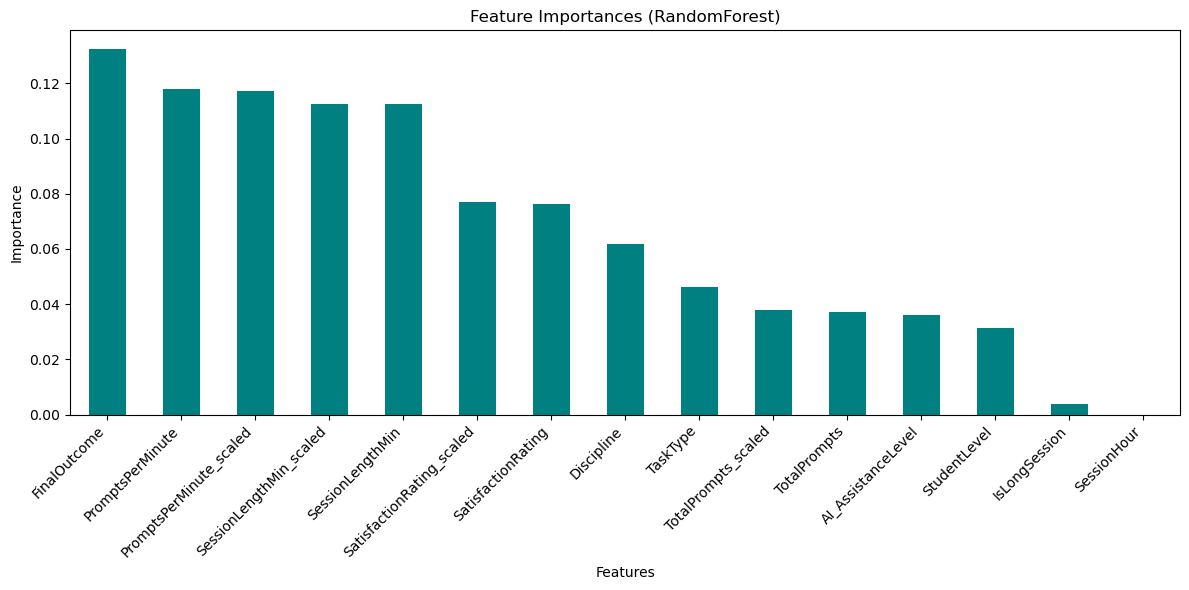

In [74]:
importances = pd.Series(model.feature_importances_, index=x.columns)
plt.figure(figsize=(12, 6))
importances.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Feature Importances (RandomForest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()